In [1]:
# Importar librerías
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap, MarkerCluster
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Librerías base cargadas")

Librerías base cargadas


In [2]:
# Intentar cargar librerías de análisis espacial
try:
    import libpysal
    from libpysal.weights import Queen, KNN, DistanceBand
    from esda.moran import Moran, Moran_Local
    from esda.getisord import G_Local
    ESDA_AVAILABLE = True
    print("Librerías ESDA disponibles")
except ImportError:
    ESDA_AVAILABLE = False
    print("Librerías ESDA no disponibles. Instalar con: pip install libpysal esda")

Librerías ESDA disponibles


## 1. Carga de Datos desde PostGIS

In [3]:
# Cargar datos desde archivos GeoJSON (alternativa a PostGIS)
import os

DATA_PATH = '../data/raw/isla_de_pascua'

# Cargar todos los datasets
datasets = {}

files = {
    'boundary': 'isla_de_pascua_boundary.geojson',
    'streets': 'isla_de_pascua_streets.geojson',
    'buildings': 'isla_de_pascua_buildings.geojson',
    'amenities': 'isla_de_pascua_amenities.geojson',
    'green_areas': 'isla_de_pascua_green_areas.geojson',
    'transport': 'isla_de_pascua_transport.geojson'
}

for name, filename in files.items():
    filepath = os.path.join(DATA_PATH, filename)
    if os.path.exists(filepath):
        datasets[name] = gpd.read_file(filepath)
        print(f"{name}: {len(datasets[name])} registros")
    else:
        print(f"{filename} no encontrado")

print(f"\nTotal datasets cargados: {len(datasets)}")

Skipping field highway: unsupported OGR type: 5
Skipping field name: unsupported OGR type: 5
Skipping field access: unsupported OGR type: 5
Skipping field width: unsupported OGR type: 5


boundary: 1 registros
streets: 4139 registros
buildings: 4045 registros
amenities: 241 registros
green_areas: 12 registros
transport: 1 registros

Total datasets cargados: 6


## 2. Análisis Exploratorio Básico

In [4]:
# Resumen de los datos
print("=" * 60)
print("RESUMEN DE DATOS - ISLA DE PASCUA")
print("=" * 60)

for name, gdf in datasets.items():
    print(f"\n{name.upper()}")
    print(f"   Registros: {len(gdf)}")
    print(f"   Tipo geometría: {gdf.geometry.geom_type.unique()}")
    print(f"   CRS: {gdf.crs}")
    print(f"   Columnas: {list(gdf.columns)[:5]}..." if len(gdf.columns) > 5 else f"   Columnas: {list(gdf.columns)}")

RESUMEN DE DATOS - ISLA DE PASCUA

BOUNDARY
   Registros: 1
   Tipo geometría: ['Polygon']
   CRS: EPSG:4326
   Columnas: ['bbox_west', 'bbox_south', 'bbox_east', 'bbox_north', 'place_id']...

STREETS
   Registros: 4139
   Tipo geometría: ['LineString']
   CRS: EPSG:4326
   Columnas: ['u', 'v', 'key', 'osmid', 'lanes']...

BUILDINGS
   Registros: 4045
   Tipo geometría: ['Polygon' 'MultiPolygon']
   CRS: EPSG:4326
   Columnas: ['element', 'id', 'amenity', 'building', 'name']...

AMENITIES
   Registros: 241
   Tipo geometría: ['Point' 'MultiPolygon' 'Polygon']
   CRS: EPSG:4326
   Columnas: ['element', 'id', 'amenity', 'name', 'source']...

GREEN_AREAS
   Registros: 12
   Tipo geometría: ['Point' 'MultiPolygon' 'Polygon']
   CRS: EPSG:4326
   Columnas: ['element', 'id', 'internet_access', 'leisure', 'opening_hours']...

TRANSPORT
   Registros: 1
   Tipo geometría: ['Point']
   CRS: EPSG:4326
   Columnas: ['element', 'id', 'amenity', 'ferry', 'name']...


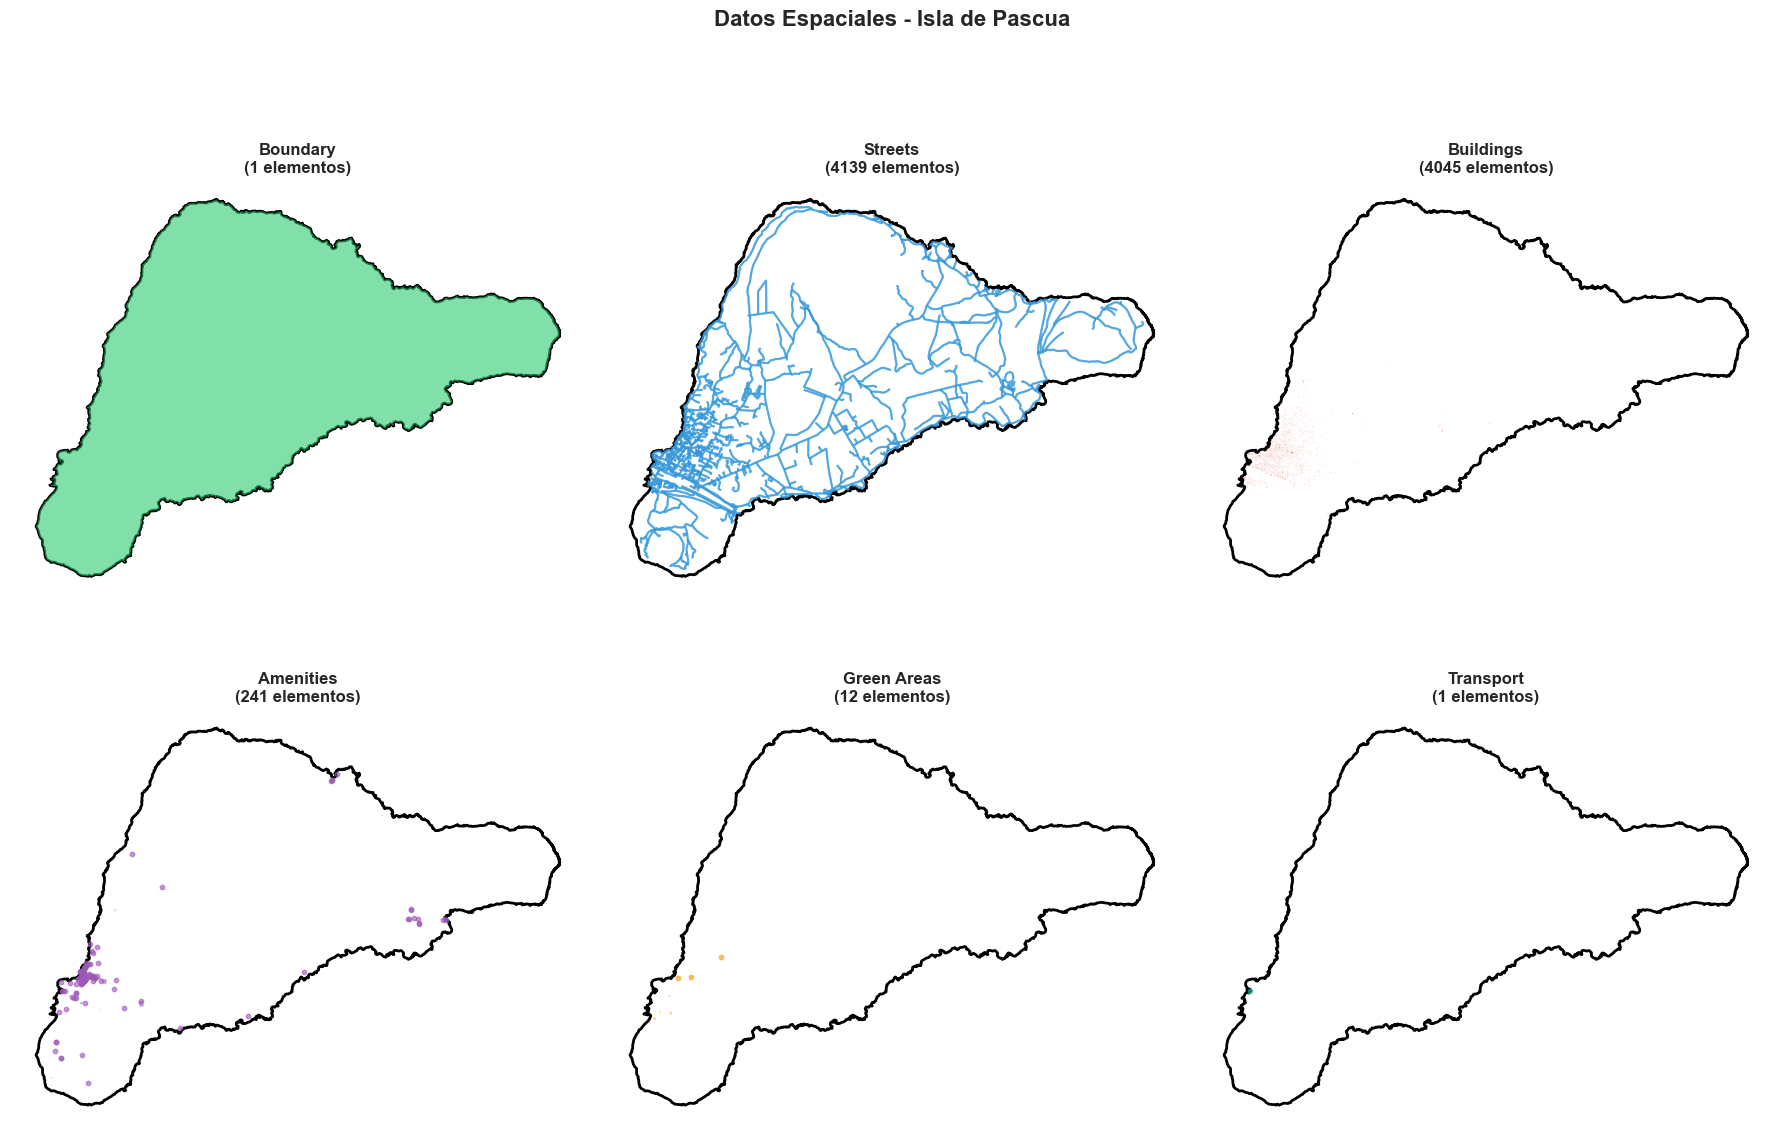

In [5]:
# Visualización básica de todos los datasets
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6', '#f39c12', '#1abc9c']

for idx, (name, gdf) in enumerate(datasets.items()):
    if idx < 6:
        ax = axes[idx]
        
        # Dibujar límite si existe
        if 'boundary' in datasets:
            datasets['boundary'].plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)
        
        # Dibujar datos
        gdf.plot(ax=ax, color=colors[idx], alpha=0.6, markersize=10 if 'Point' in str(gdf.geometry.geom_type.unique()) else None)
        
        ax.set_title(f'{name.replace("_", " ").title()}\n({len(gdf)} elementos)', fontsize=12, fontweight='bold')
        ax.set_axis_off()

plt.suptitle('Datos Espaciales - Isla de Pascua', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../outputs/01_overview_datasets.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Análisis de Edificios

In [6]:
# Análisis detallado de edificios
buildings = datasets['buildings'].copy()

# Calcular áreas
buildings_proj = buildings.to_crs(epsg=32719)  # UTM 19S para Chile
buildings['area_m2'] = buildings_proj.geometry.area

print("ESTADÍSTICAS DE EDIFICIOS")
print("=" * 40)
print(f"Total edificios: {len(buildings)}")
print(f"\nÁrea (m²):")
print(f"  - Mínima: {buildings['area_m2'].min():.2f}")
print(f"  - Máxima: {buildings['area_m2'].max():.2f}")
print(f"  - Promedio: {buildings['area_m2'].mean():.2f}")
print(f"  - Mediana: {buildings['area_m2'].median():.2f}")
print(f"  - Desv. Est.: {buildings['area_m2'].std():.2f}")

ESTADÍSTICAS DE EDIFICIOS
Total edificios: 4045

Área (m²):
  - Mínima: 5.09
  - Máxima: 11121.62
  - Promedio: 203.05
  - Mediana: 153.80
  - Desv. Est.: 319.65


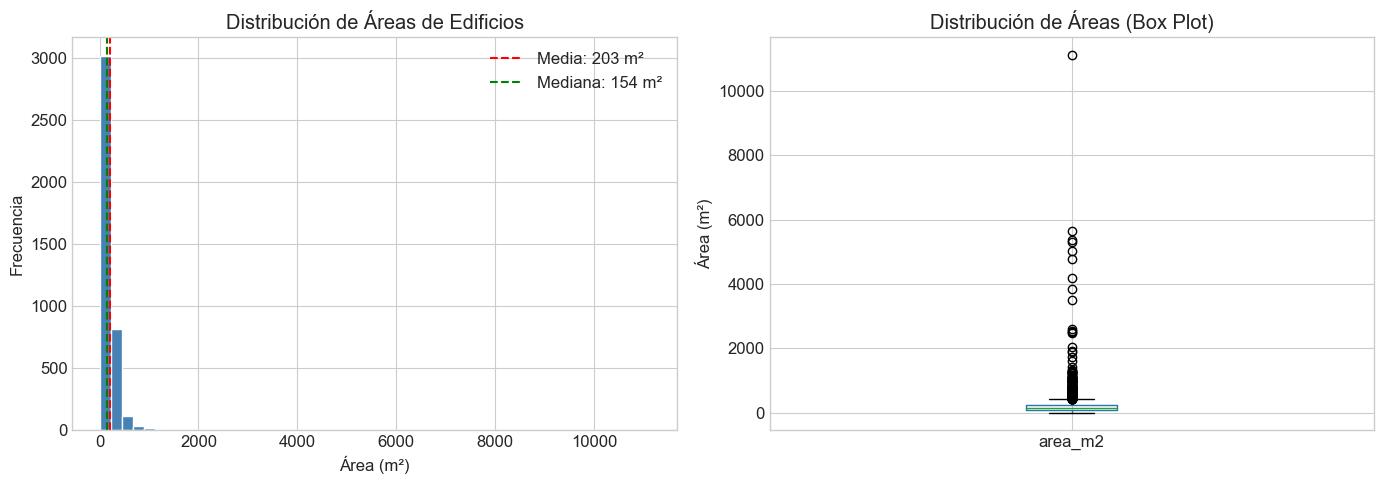

In [7]:
# Histograma de áreas de edificios
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
ax1 = axes[0]
buildings['area_m2'].hist(bins=50, ax=ax1, color='steelblue', edgecolor='white')
ax1.set_xlabel('Área (m²)')
ax1.set_ylabel('Frecuencia')
ax1.set_title('Distribución de Áreas de Edificios')
ax1.axvline(buildings['area_m2'].mean(), color='red', linestyle='--', label=f'Media: {buildings["area_m2"].mean():.0f} m²')
ax1.axvline(buildings['area_m2'].median(), color='green', linestyle='--', label=f'Mediana: {buildings["area_m2"].median():.0f} m²')
ax1.legend()

# Box plot
ax2 = axes[1]
buildings.boxplot(column='area_m2', ax=ax2)
ax2.set_ylabel('Área (m²)')
ax2.set_title('Distribución de Áreas (Box Plot)')

plt.tight_layout()
plt.savefig('../outputs/02_buildings_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

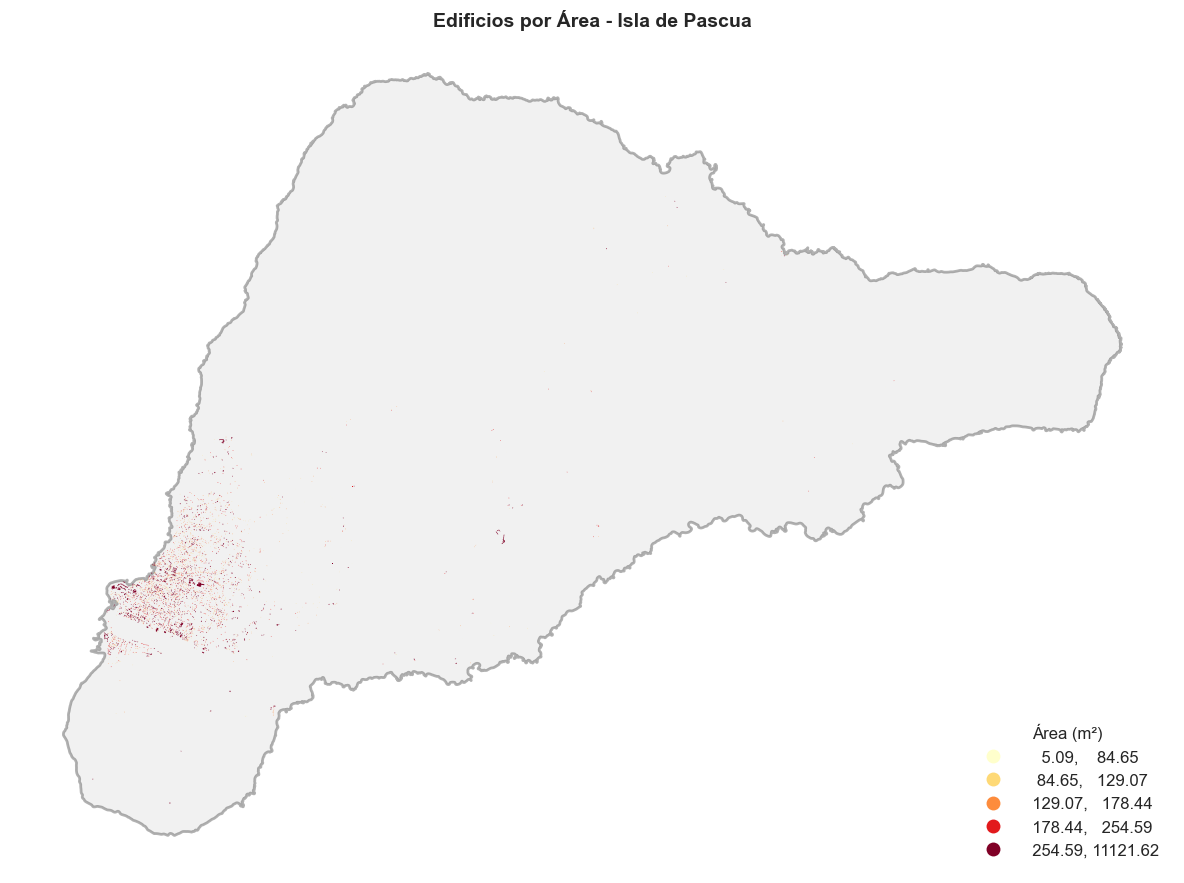

In [8]:
# Mapa coroplético de edificios por área
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Clasificar edificios por área
buildings['area_class'] = pd.cut(buildings['area_m2'], 
                                  bins=[0, 50, 100, 200, 500, float('inf')],
                                  labels=['<50m²', '50-100m²', '100-200m²', '200-500m²', '>500m²'])

# Dibujar límite
if 'boundary' in datasets:
    datasets['boundary'].plot(ax=ax, facecolor='lightgray', edgecolor='black', linewidth=2, alpha=0.3)

# Dibujar edificios coloreados por área
buildings.plot(column='area_m2', ax=ax, legend=True, 
               cmap='YlOrRd', scheme='quantiles', k=5,
               legend_kwds={'title': 'Área (m²)', 'loc': 'lower right'})

ax.set_title('Edificios por Área - Isla de Pascua', fontsize=14, fontweight='bold')
ax.set_axis_off()

plt.tight_layout()
plt.savefig('../outputs/03_buildings_area_map.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Análisis de Amenidades

TIPOS DE AMENIDADES
amenity
restaurant          65
parking             50
cafe                15
place_of_worship    14
bench               12
toilets             10
car_rental           8
school               8
community_centre     7
pub                  4
courthouse           4
prison               4
fast_food            3
bar                  3
marketplace          3
Name: count, dtype: int64


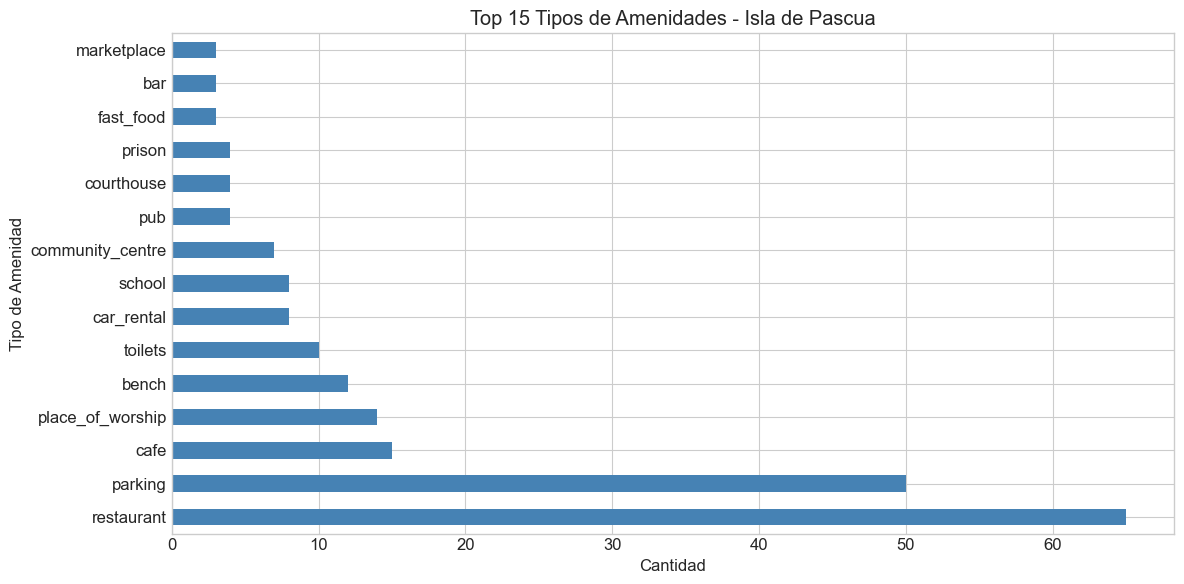

In [9]:
# Análisis de amenidades
amenities = datasets['amenities'].copy()

# Verificar columna amenity
if 'amenity' in amenities.columns:
    print("TIPOS DE AMENIDADES")
    print("=" * 40)
    amenity_counts = amenities['amenity'].value_counts().head(15)
    print(amenity_counts)
    
    # Gráfico de barras
    fig, ax = plt.subplots(figsize=(12, 6))
    amenity_counts.plot(kind='barh', ax=ax, color='steelblue')
    ax.set_xlabel('Cantidad')
    ax.set_ylabel('Tipo de Amenidad')
    ax.set_title('Top 15 Tipos de Amenidades - Isla de Pascua')
    plt.tight_layout()
    plt.savefig('../outputs/04_amenities_types.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Columnas disponibles:", amenities.columns.tolist())

## 5. Análisis de Densidad

In [10]:
# Crear grilla para análisis de densidad
from shapely.geometry import box

# Obtener bounds del área de estudio
boundary = datasets['boundary']
minx, miny, maxx, maxy = boundary.total_bounds

# Crear grilla de celdas
cell_size = 0.005  # Aproximadamente 500m en grados
grid_cells = []
x = minx
while x < maxx:
    y = miny
    while y < maxy:
        grid_cells.append(box(x, y, x + cell_size, y + cell_size))
        y += cell_size
    x += cell_size

grid = gpd.GeoDataFrame(geometry=grid_cells, crs=boundary.crs)

# Filtrar celdas que intersectan con el límite
grid = grid[grid.intersects(boundary.unary_union)]

print(f"Grilla creada: {len(grid)} celdas")

Grilla creada: 678 celdas


In [11]:
# Calcular densidad de edificios por celda
buildings_centroids = buildings.copy()
buildings_centroids['geometry'] = buildings_centroids.geometry.centroid

# Contar edificios por celda
grid['building_count'] = 0
for idx, cell in grid.iterrows():
    count = buildings_centroids[buildings_centroids.within(cell.geometry)].shape[0]
    grid.loc[idx, 'building_count'] = count

print(f"Estadísticas de densidad:")
print(f"   Min: {grid['building_count'].min()}")
print(f"   Max: {grid['building_count'].max()}")
print(f"   Promedio: {grid['building_count'].mean():.2f}")

Estadísticas de densidad:
   Min: 0
   Max: 333
   Promedio: 5.97


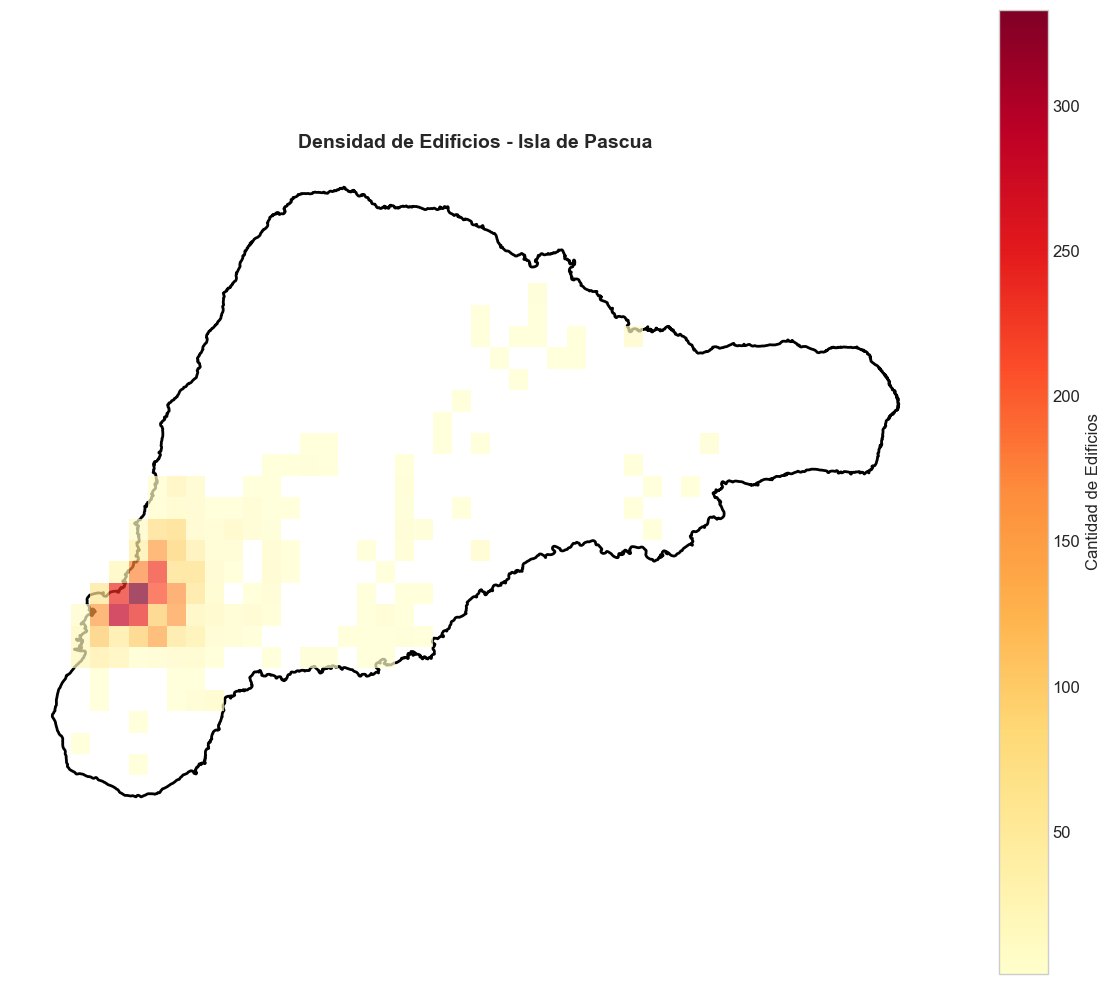

In [12]:
# Mapa de densidad
fig, ax = plt.subplots(figsize=(12, 10))

# Solo celdas con edificios
grid_with_buildings = grid[grid['building_count'] > 0]

# Dibujar límite
boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)

# Dibujar grilla con densidad
grid_with_buildings.plot(column='building_count', ax=ax, 
                         cmap='YlOrRd', legend=True, alpha=0.7,
                         legend_kwds={'label': 'Cantidad de Edificios'})

ax.set_title('Densidad de Edificios - Isla de Pascua', fontsize=14, fontweight='bold')
ax.set_axis_off()

plt.tight_layout()
plt.savefig('../outputs/05_density_map.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Autocorrelación Espacial (Moran's I)

In [13]:
if ESDA_AVAILABLE:
    # Usar solo celdas con edificios
    analysis_grid = grid_with_buildings[grid_with_buildings['building_count'] > 0].copy()
    analysis_grid = analysis_grid.reset_index(drop=True)
    
    if len(analysis_grid) > 10:
        # Crear matriz de pesos espaciales
        w = Queen.from_dataframe(analysis_grid)
        w.transform = 'r'  # Row-standardize
        
        # Calcular Moran's I global
        y = analysis_grid['building_count'].values
        moran = Moran(y, w)
        
        print("AUTOCORRELACIÓN ESPACIAL GLOBAL (Moran's I)")
        print("=" * 50)
        print(f"Moran's I: {moran.I:.4f}")
        print(f"Valor esperado: {moran.EI:.4f}")
        print(f"Varianza: {moran.VI_norm:.6f}")
        print(f"Z-score: {moran.z_norm:.4f}")
        print(f"P-value: {moran.p_norm:.6f}")
        print("\nInterpretación:")
        if moran.p_norm < 0.05:
            if moran.I > 0:
                print("   Existe autocorrelación espacial POSITIVA significativa")
                print("   → Los valores similares tienden a estar agrupados")
            else:
                print("   Existe autocorrelación espacial NEGATIVA significativa")
                print("   → Los valores tienden a dispersarse")
        else:
            print("No hay autocorrelación espacial significativa")
    else:
        print("No hay suficientes celdas para el análisis")
else:
    print("Librerías ESDA no disponibles")

('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 15, ' is an island (no neighbors)')
('WARNING: ', 16, ' is an island (no neighbors)')
('WARNING: ', 118, ' is an island (no neighbors)')
('WARNING: ', 120, ' is an island (no neighbors)')
('WARNING: ', 121, ' is an island (no neighbors)')
('WARNING: ', 135, ' is an island (no neighbors)')
('WARNING: ', 138, ' is an island (no neighbors)')
('WARNING: ', 139, ' is an island (no neighbors)')
AUTOCORRELACIÓN ESPACIAL GLOBAL (Moran's I)
Moran's I: 0.7258
Valor esperado: -0.0072
Varianza: 0.004019
Z-score: 11.5622
P-value: 0.000000

Interpretación:
   Existe autocorrelación espacial POSITIVA significativa
   → Los valores similares tienden a estar agrupados


## 7. Identificación de Hot Spots (LISA)

In [14]:
if ESDA_AVAILABLE and len(analysis_grid) > 10:
    # Calcular LISA (Local Moran's I)
    lisa = Moran_Local(y, w)
    
    # Agregar resultados al dataframe
    analysis_grid['lisa_i'] = lisa.Is
    analysis_grid['lisa_q'] = lisa.q  # Cuadrante LISA
    analysis_grid['lisa_p'] = lisa.p_sim
    analysis_grid['significant'] = lisa.p_sim < 0.05
    
    # Clasificar clusters
    def classify_lisa(row):
        if not row['significant']:
            return 'No Significativo'
        q = row['lisa_q']
        if q == 1:
            return 'High-High (Hot Spot)'
        elif q == 2:
            return 'Low-High'
        elif q == 3:
            return 'Low-Low (Cold Spot)'
        else:
            return 'High-Low'
    
    analysis_grid['cluster_type'] = analysis_grid.apply(classify_lisa, axis=1)
    
    print("ANÁLISIS LISA (Hot Spots y Cold Spots)")
    print("=" * 50)
    print(analysis_grid['cluster_type'].value_counts())
else:
    print("No se puede realizar análisis LISA")

ANÁLISIS LISA (Hot Spots y Cold Spots)
cluster_type
No Significativo        82
Low-Low (Cold Spot)     37
High-High (Hot Spot)    20
Low-High                 1
Name: count, dtype: int64


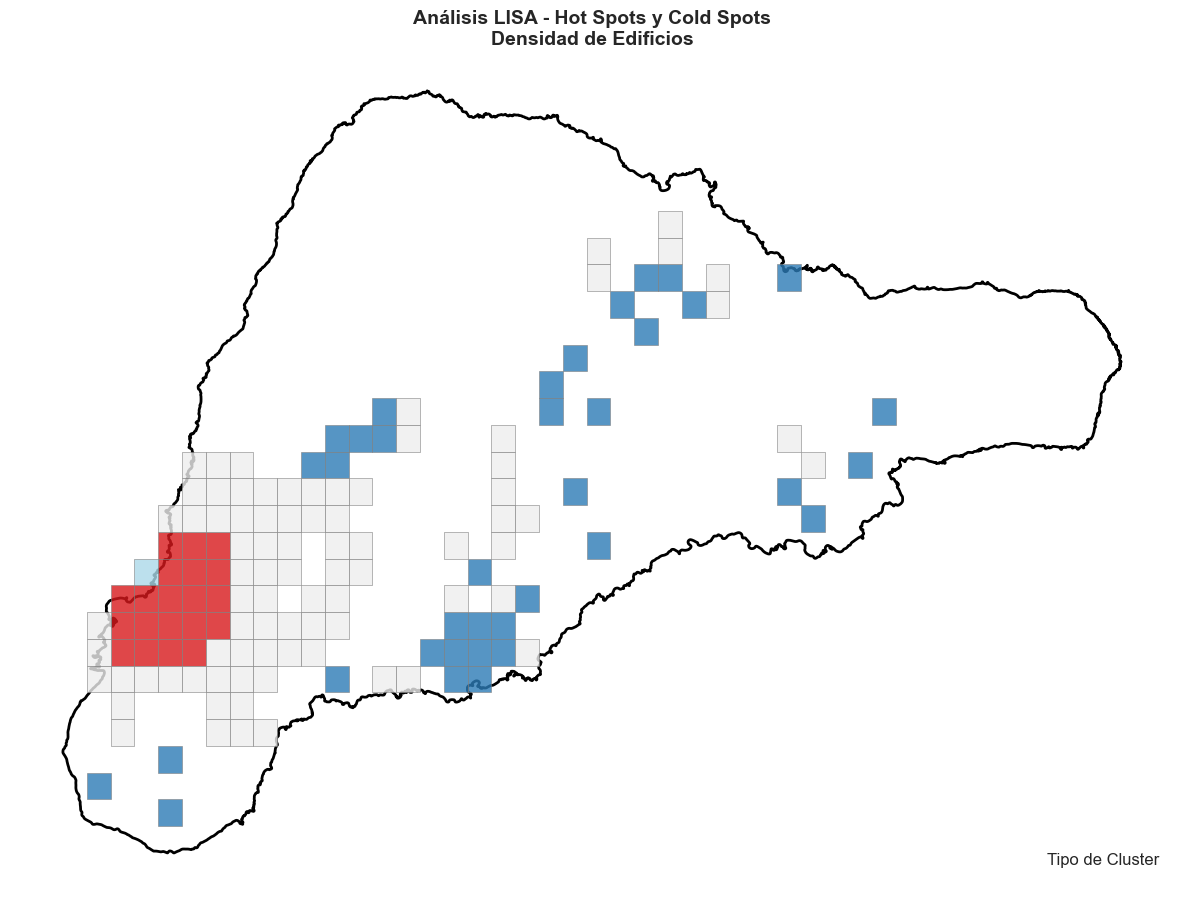

In [15]:
if ESDA_AVAILABLE and 'cluster_type' in analysis_grid.columns:
    # Mapa de clusters LISA
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Colores para cada tipo de cluster
    colors = {
        'High-High (Hot Spot)': '#d7191c',
        'Low-Low (Cold Spot)': '#2c7bb6',
        'High-Low': '#fdae61',
        'Low-High': '#abd9e9',
        'No Significativo': '#eeeeee'
    }
    
    # Dibujar límite
    boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)
    
    # Dibujar clusters
    for cluster_type, color in colors.items():
        subset = analysis_grid[analysis_grid['cluster_type'] == cluster_type]
        if len(subset) > 0:
            subset.plot(ax=ax, color=color, edgecolor='gray', linewidth=0.5, 
                       alpha=0.8, label=f"{cluster_type} ({len(subset)})")
    
    ax.legend(loc='lower right', title='Tipo de Cluster')
    ax.set_title('Análisis LISA - Hot Spots y Cold Spots\nDensidad de Edificios', fontsize=14, fontweight='bold')
    ax.set_axis_off()
    
    plt.tight_layout()
    plt.savefig('../outputs/06_lisa_clusters.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No hay datos de clusters para visualizar")

## 8. Mapa Interactivo con Folium

In [16]:
# Crear mapa interactivo
center = [boundary.geometry.centroid.y.values[0], boundary.geometry.centroid.x.values[0]]
m = folium.Map(location=center, zoom_start=13, tiles='CartoDB positron')

# Añadir límite
folium.GeoJson(
    boundary,
    name='Límite',
    style_function=lambda x: {'fillColor': 'transparent', 'color': 'black', 'weight': 3}
).add_to(m)

# Añadir edificios como heatmap
building_points = [[p.y, p.x] for p in buildings.geometry.centroid]
HeatMap(building_points, name='Densidad Edificios', radius=15).add_to(m)

# Añadir amenidades con markers
if 'amenities' in datasets:
    amenity_cluster = MarkerCluster(name='Amenidades')
    for idx, row in amenities.iterrows():
        if row.geometry.geom_type == 'Point':
            popup_text = row.get('name', row.get('amenity', 'Amenidad'))
            folium.Marker(
                location=[row.geometry.y, row.geometry.x],
                popup=str(popup_text),
                icon=folium.Icon(color='blue', icon='info-sign')
            ).add_to(amenity_cluster)
    amenity_cluster.add_to(m)

# Control de capas
folium.LayerControl().add_to(m)

# Guardar mapa
m.save('../outputs/07_mapa_interactivo.html')
print("Mapa guardado en outputs/07_mapa_interactivo.html")
m

Mapa guardado en outputs/07_mapa_interactivo.html


## 9. Resumen del Análisis

In [17]:
print("\n" + "="*60)
print("RESUMEN DEL ANÁLISIS EXPLORATORIO")
print("="*60)

print("\nDATOS ANALIZADOS:")
for name, gdf in datasets.items():
    print(f"   • {name}: {len(gdf)} elementos")

print("\nEDIFICIOS:")
print(f"   • Total: {len(buildings)}")
print(f"   • Área promedio: {buildings['area_m2'].mean():.2f} m²")
print(f"   • Área mediana: {buildings['area_m2'].median():.2f} m²")

if ESDA_AVAILABLE and 'moran' in dir():
    print("\nAUTOCORRELACIÓN ESPACIAL:")
    print(f"   • Moran's I: {moran.I:.4f}")
    print(f"   • P-value: {moran.p_norm:.6f}")
    print(f"   • Interpretación: {'Significativo' if moran.p_norm < 0.05 else 'No significativo'}")

if 'cluster_type' in analysis_grid.columns:
    print("\nHOT SPOTS (LISA):")
    for ct, count in analysis_grid['cluster_type'].value_counts().items():
        print(f"   • {ct}: {count}")

print("\nARCHIVOS GENERADOS:")
print("   • outputs/01_overview_datasets.png")
print("   • outputs/02_buildings_distribution.png")
print("   • outputs/03_buildings_area_map.png")
print("   • outputs/04_amenities_types.png")
print("   • outputs/05_density_map.png")
print("   • outputs/06_lisa_clusters.png")
print("   • outputs/07_mapa_interactivo.html")
print("\nAnálisis exploratorio completado!")


RESUMEN DEL ANÁLISIS EXPLORATORIO

DATOS ANALIZADOS:
   • boundary: 1 elementos
   • streets: 4139 elementos
   • buildings: 4045 elementos
   • amenities: 241 elementos
   • green_areas: 12 elementos
   • transport: 1 elementos

EDIFICIOS:
   • Total: 4045
   • Área promedio: 203.05 m²
   • Área mediana: 153.80 m²

AUTOCORRELACIÓN ESPACIAL:
   • Moran's I: 0.7258
   • P-value: 0.000000
   • Interpretación: Significativo

HOT SPOTS (LISA):
   • No Significativo: 82
   • Low-Low (Cold Spot): 37
   • High-High (Hot Spot): 20
   • Low-High: 1

ARCHIVOS GENERADOS:
   • outputs/01_overview_datasets.png
   • outputs/02_buildings_distribution.png
   • outputs/03_buildings_area_map.png
   • outputs/04_amenities_types.png
   • outputs/05_density_map.png
   • outputs/06_lisa_clusters.png
   • outputs/07_mapa_interactivo.html

Análisis exploratorio completado!
